# Table of Contents
1. [Introduction](#Introduction)
1. [Data Loading](#Data-Loading)
1. [Data Preprocessing](#Data-Preprocessing)
   - [Handling Missing Values](#Handling-Missing-Values)
   - [Outliers Detection](#Outliers-Detection)
   - [Handling categorical data](#Handling-categorical-data)
1. [Data exploration](#Data-exploration)
   - [Personality type playlist distribution](#Personality-type-playlist-distribution)
   - [Song feature preferences by personality type](#Song-feature-preferences-by-personality-type)
   - [Heatmap of core features](#Heatmap-of-all-core-features)
   - [Energy and danceability relationship](#Energy-and-danceability)
   - [Natural clustering of Personality Types Based on Music Features](#Natural-clustering-of-Personality-Types-Based-on-Music-Features)
   - [Feature "importance"](#Feature-"importance")
1. [Model development](#Model-development)
   - [Profile each MBTI type](#Profile-each-MBTI-type)
   - [Compute similarity score](#Compute-similarity-score)

## Introduction


## Data Loading

In [3]:
import pandas as pd

df = pd.read_csv('combined_mbti_df.csv.zip', compression='zip', encoding='utf-8')
df.head()

,mbti,function_pair,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,...,Aminor_count,AMajor_count,A#/Bbminor_count,BMajor_count,Dminor_count,D#_Ebminor_count,Gminor_count,A#/BbMajor_count,F#/GbMajor_count,Bminor_count
0,INFP,NF,0.557841,0.155011,0.553325,0.225178,-8.352591,3.273317,0.659091,0.479495,...,2.0,2.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0
1,INFP,NF,0.587636,0.135644,0.556273,0.191642,-8.215697,3.356867,0.636364,0.488504,...,1.0,2.0,1.0,4.0,1.0,1.0,1.0,1.0,0.0,0.0
2,INFP,NF,0.677000,0.128009,0.851280,0.128336,-5.046100,2.180554,0.580000,0.498569,...,0.0,1.0,1.0,3.0,1.0,0.0,0.0,1.0,2.0,9.0
3,INFP,NF,0.517000,0.169477,0.513412,0.258345,-10.172833,4.935140,0.785714,0.415300,...,2.0,5.0,0.0,2.0,0.0,1.0,0.0,3.0,0.0,0.0
4,INFP,NF,0.560400,0.141450,0.445862,0.242592,-10.572240,5.685179,0.820000,0.388088,...,1.0,7.0,2.0,1.0,0.0,0.0,0.0,5.0,1.0,1.0


## Data Preprocessing

### Handling Missing Values
Handle missing values in the dataset, using imputation.


In [11]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    df[column].fillna(df[column].median(), inplace=True)

missing_values_after_imputation = df[numeric_columns].isnull().sum().sum()
missing_values_after_imputation


0

### Outliers Detection
 Identify outliers using the IQR method for the continuous columns


In [12]:
# Identify continuous features
continuous_features = []

for feature in df.select_dtypes(include=['float64', 'int64']):
    unique_counts = df[feature].nunique()
    total_counts = len(df[feature])
    # If the number of unique values is less than 1% of the total count, we'll consider it categorical
    if unique_counts / total_counts > 0.01:
        continuous_features.append(feature)

continuous_features

['danceability_mean',
 'danceability_stdev',
 'energy_mean',
 'energy_stdev',
 'loudness_mean',
 'loudness_stdev',
 'mode_mean',
 'mode_stdev',
 'speechiness_mean',
 'speechiness_stdev',
 'acousticness_mean',
 'acousticness_stdev',
 'liveness_mean',
 'liveness_stdev',
 'valence_mean',
 'valence_stdev',
 'tempo_mean',
 'tempo_stdev',
 'instrumentalness_mean',
 'instrumentalness_stdev']

In [16]:
outliers_data = {}

for feature in continuous_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_count = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].shape[0]
    outliers_indices = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)].index.tolist()

    outliers_data[feature] = {"count": outliers_count, "indices": outliers_indices}


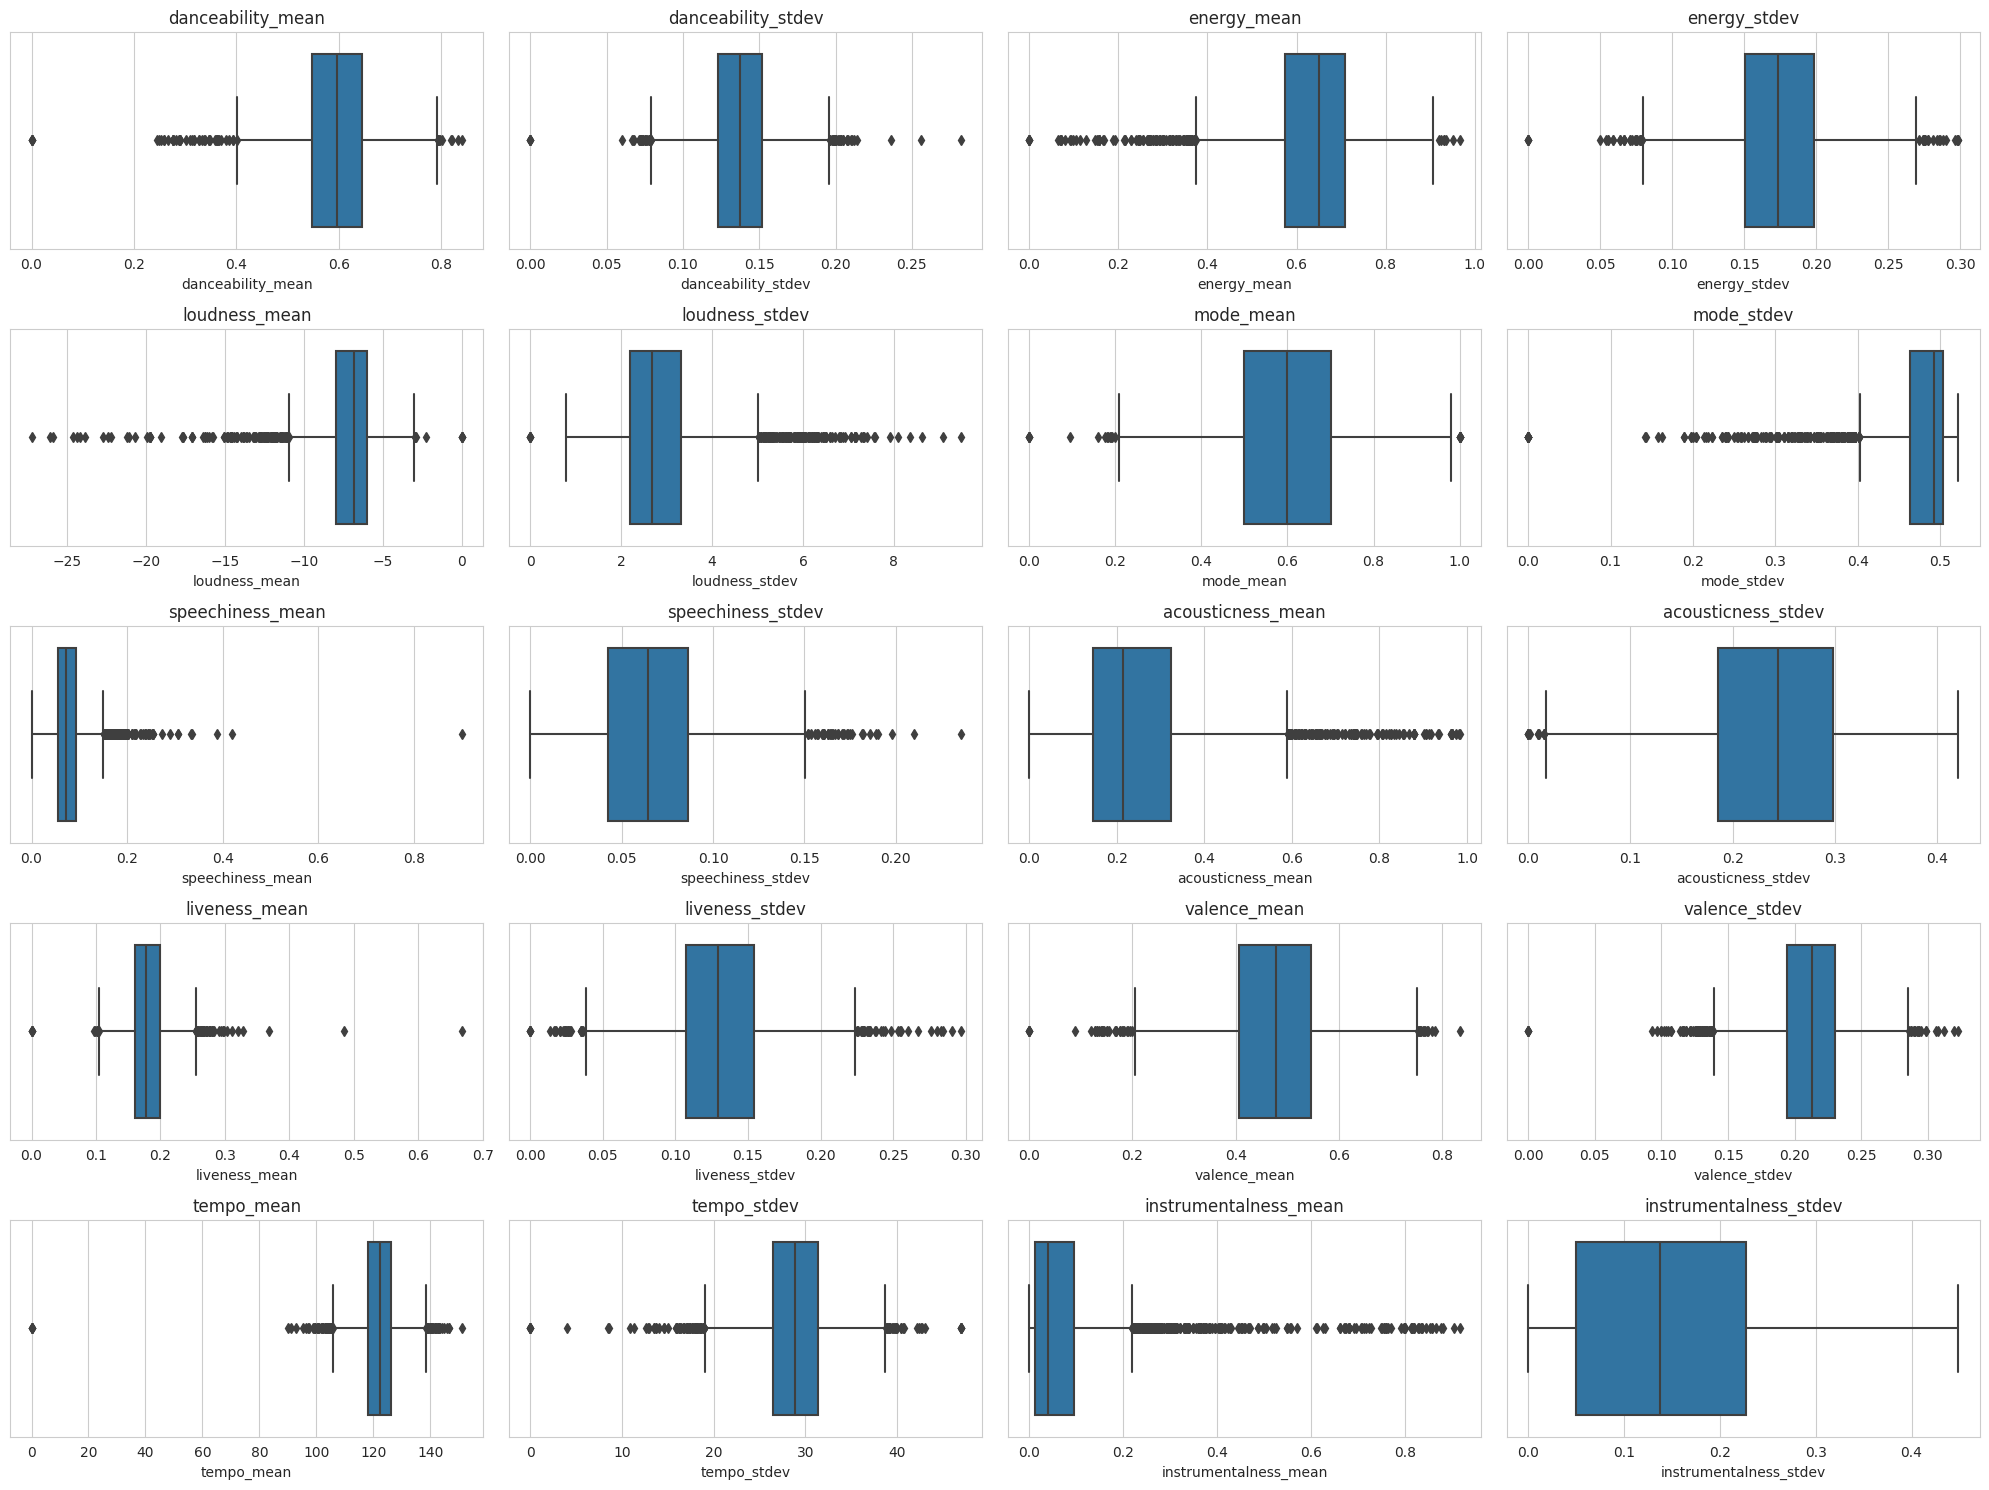

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")

for i, feature in enumerate(continuous_features, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x=df[feature])
    plt.title(feature)
    plt.tight_layout()

plt.show()

Given the subjective nature of music and there being a variety of tastes, there might be value in leaving the outliers as they are. Perhaps these are genuine values rather than statistical anomalies.
Further domain knowledge would be required.
A decision was made to keep the outliers as they are for now.

### Handling categorical data
One-hot encoding for the 'mbti' and 'function_pair' columns

In [19]:
df_encoded = pd.get_dummies(df, columns=['mbti', 'function_pair'], drop_first=True)

df_encoded.head()

,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,speechiness_stdev,...,mbti_INFP,mbti_INTJ,mbti_INTP,mbti_ISFJ,mbti_ISFP,mbti_ISTJ,mbti_ISTP,function_pair_NT,function_pair_SJ,function_pair_SP
0,0.557841,0.155011,0.553325,0.225178,-8.352591,3.273317,0.659091,0.479495,0.067341,0.061083,...,1,0,0,0,0,0,0,0,0,0
1,0.587636,0.135644,0.556273,0.191642,-8.215697,3.356867,0.636364,0.488504,0.074273,0.083388,...,1,0,0,0,0,0,0,0,0,0
2,0.677000,0.128009,0.851280,0.128336,-5.046100,2.180554,0.580000,0.498569,0.272546,0.176013,...,1,0,0,0,0,0,0,0,0,0
3,0.517000,0.169477,0.513412,0.258345,-10.172833,4.935140,0.785714,0.415300,0.051510,0.033911,...,1,0,0,0,0,0,0,0,0,0
4,0.560400,0.141450,0.445862,0.242592,-10.572240,5.685179,0.820000,0.388088,0.065178,0.058684,...,1,0,0,0,0,0,0,0,0,0


## Data exploration

### Personality type playlist distribution

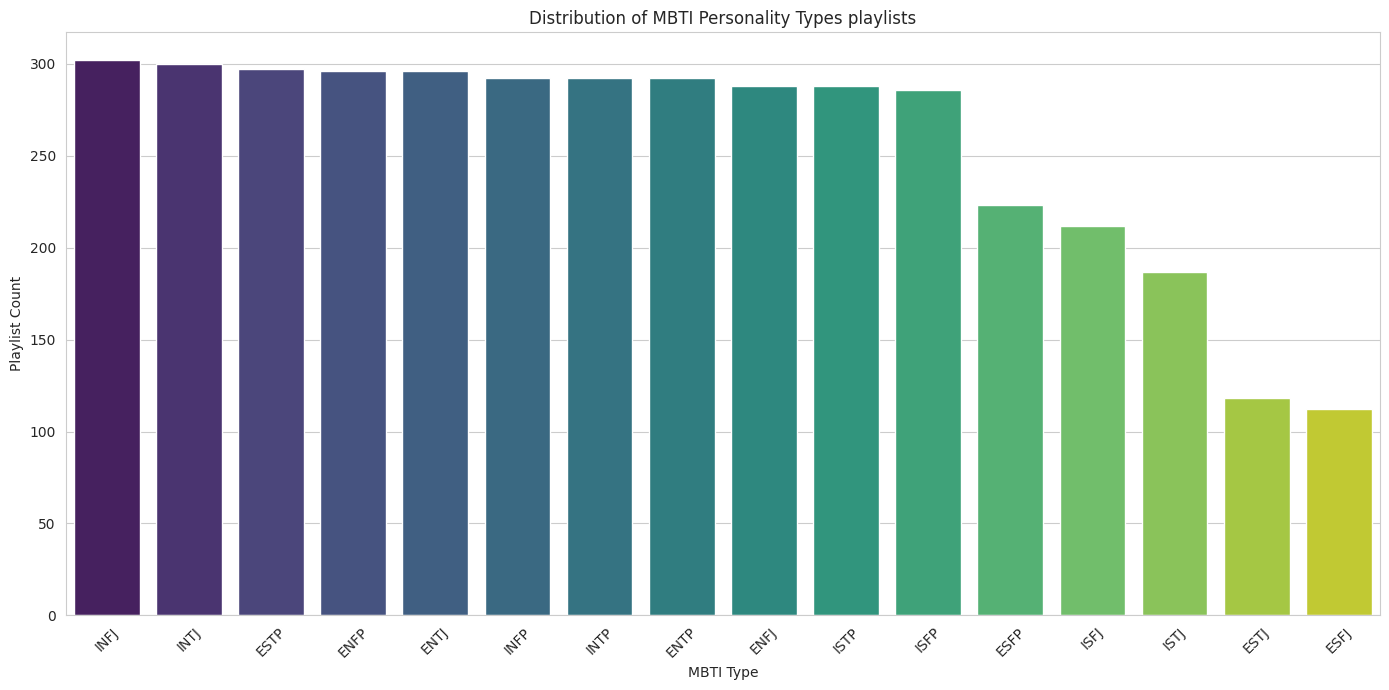

In [20]:
# Visualizing the distribution of personality types (mbti)
plt.figure(figsize=(14, 7))
sns.countplot(data=df, x='mbti', order=df['mbti'].value_counts().index, palette='viridis')
plt.title('Distribution of MBTI Personality Types playlists')
plt.ylabel('Count')
plt.xlabel('MBTI Type')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

The dataset displays noticeable imbalances among the MBTI personality types. This raises the question: Is the imbalance a byproduct of the dataset's collection methodology, or do some personality types inherently have fewer representatives who actively create playlists?

It's plausible that individuals with specific personality traits might be less inclined to take the lead and curate playlists on Spotify, contributing to the observed disparity.

If certain personality types are indeed rarer in the general population, any potential accuracy shortcomings related to these types would impact a smaller subset of users, thus somewhat mitigating the overall effect of the imbalance on the user base of our recommendation system.

### Song feature preferences by personality type

In [21]:
# Aggregating music features by personality type
agg_features = df.groupby('mbti').mean()
agg_features.reset_index(inplace=True)

agg_features

<ipython-input-21-c19182dffc59>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_features = df.groupby('mbti').mean()


,mbti,danceability_mean,danceability_stdev,energy_mean,energy_stdev,loudness_mean,loudness_stdev,mode_mean,mode_stdev,speechiness_mean,...,Aminor_count,AMajor_count,A#/Bbminor_count,BMajor_count,Dminor_count,D#_Ebminor_count,Gminor_count,A#/BbMajor_count,F#/GbMajor_count,Bminor_count
0,ENFJ,0.587899,0.132916,0.613069,0.172961,-7.350223,2.764660,0.668101,0.449921,0.071001,...,1.635417,2.618056,1.017361,1.312500,0.673611,0.361111,0.875000,1.312500,1.513889,1.732639
1,ENFP,0.617160,0.132570,0.665137,0.171269,-6.686634,2.716257,0.642880,0.468416,0.073006,...,1.554054,2.851351,1.189189,1.243243,0.685811,0.483108,1.094595,1.432432,1.594595,1.972973
2,ENTJ,0.631979,0.136586,0.677213,0.157506,-6.374244,2.483332,0.492467,0.492934,0.100175,...,2.510135,1.527027,2.141892,0.976351,1.084459,0.388514,1.402027,0.834459,1.408784,2.199324
3,ENTP,0.631851,0.142968,0.688228,0.165099,-6.378168,2.592441,0.526433,0.494604,0.094166,...,2.496575,1.674658,1.811644,1.243151,0.958904,0.558219,1.044521,0.945205,1.301370,2.743151
4,ESFJ,0.597484,0.129435,0.628275,0.171115,-6.906210,2.631162,0.661813,0.446618,0.071973,...,1.080357,2.491071,1.178571,1.187500,0.392857,0.285714,1.196429,1.401786,1.455357,1.678571
5,ESFP,0.638366,0.128698,0.691941,0.162474,-6.265767,2.528965,0.597945,0.473732,0.083037,...,1.313901,2.210762,1.367713,1.089686,0.726457,0.511211,1.206278,1.035874,1.385650,2.035874
6,ESTJ,0.628262,0.132297,0.659110,0.159432,-6.607564,2.479501,0.535391,0.479082,0.094724,...,1.923729,1.889831,1.991525,1.271186,1.059322,0.542373,1.101695,0.754237,1.161017,2.330508
7,ESTP,0.636329,0.136978,0.704636,0.155061,-6.224988,2.472459,0.554658,0.485514,0.104276,...,2.023569,1.835017,1.895623,1.656566,0.680135,0.558923,1.279461,0.969697,1.222222,2.612795
8,INFJ,0.552437,0.134843,0.564813,0.189176,-8.017217,3.245388,0.639508,0.461769,0.060858,...,1.629139,2.523179,1.082781,1.473510,0.943709,0.324503,0.986755,1.976821,1.745033,2.172185
9,INFP,0.568625,0.135982,0.572403,0.188434,-7.908142,3.229462,0.655904,0.456050,0.068767,...,1.698630,2.900685,1.123288,1.503425,0.955479,0.476027,0.996575,1.808219,1.842466,1.599315


In [24]:
selected_features = ['danceability_mean', 'energy_mean', 'acousticness_mean', 'valence_mean']

### Heatmap of all core features

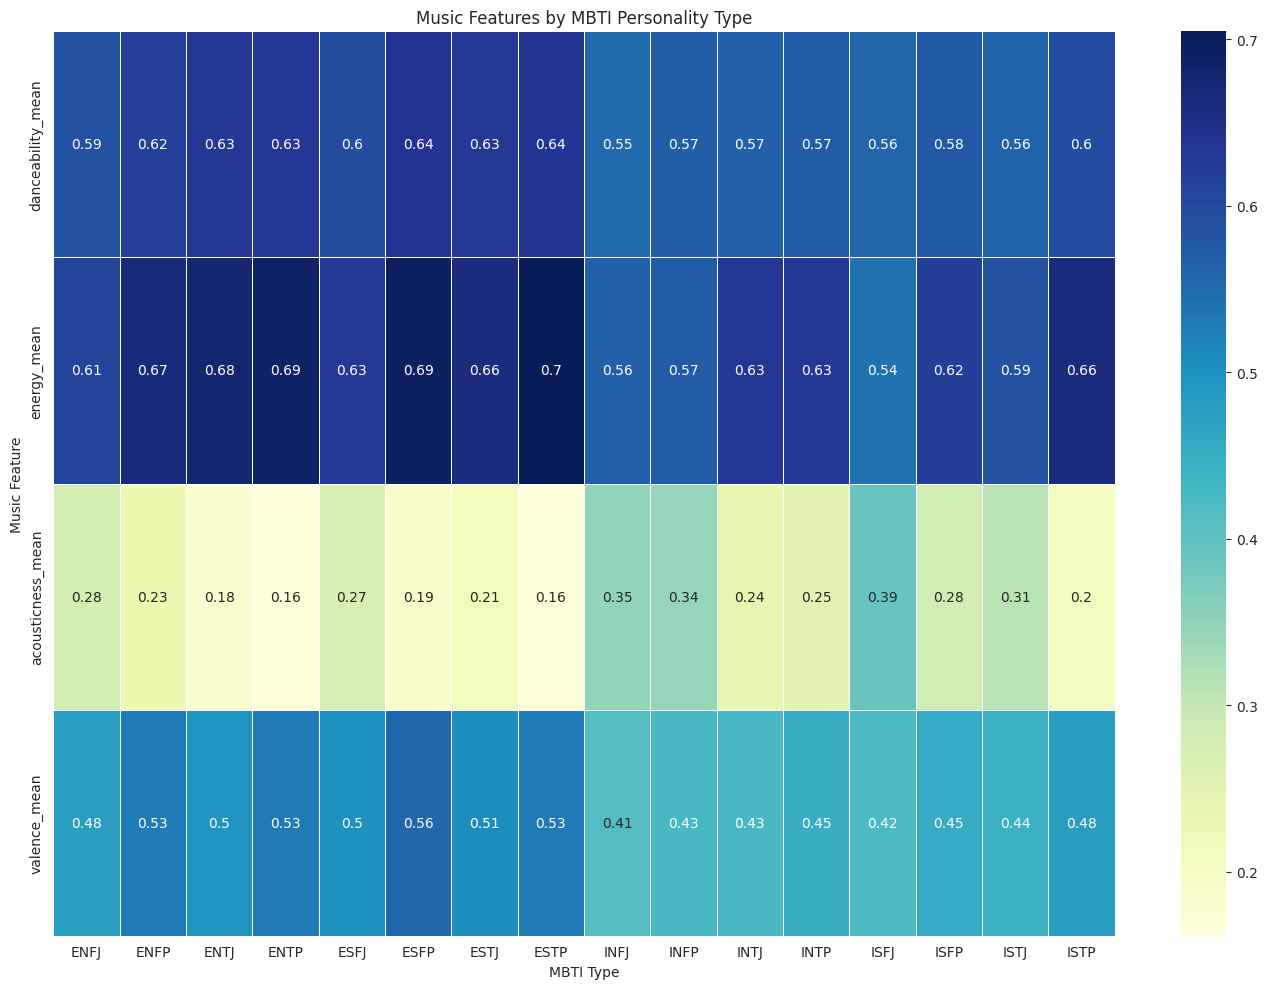

In [25]:
heatmap_data = agg_features.set_index('mbti')[selected_features].transpose()

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, linewidths=.5)
plt.title('Music Features by MBTI Personality Type')
plt.xlabel('MBTI Type')
plt.ylabel('Music Feature')
plt.tight_layout()

plt.show()

### Energy and danceability

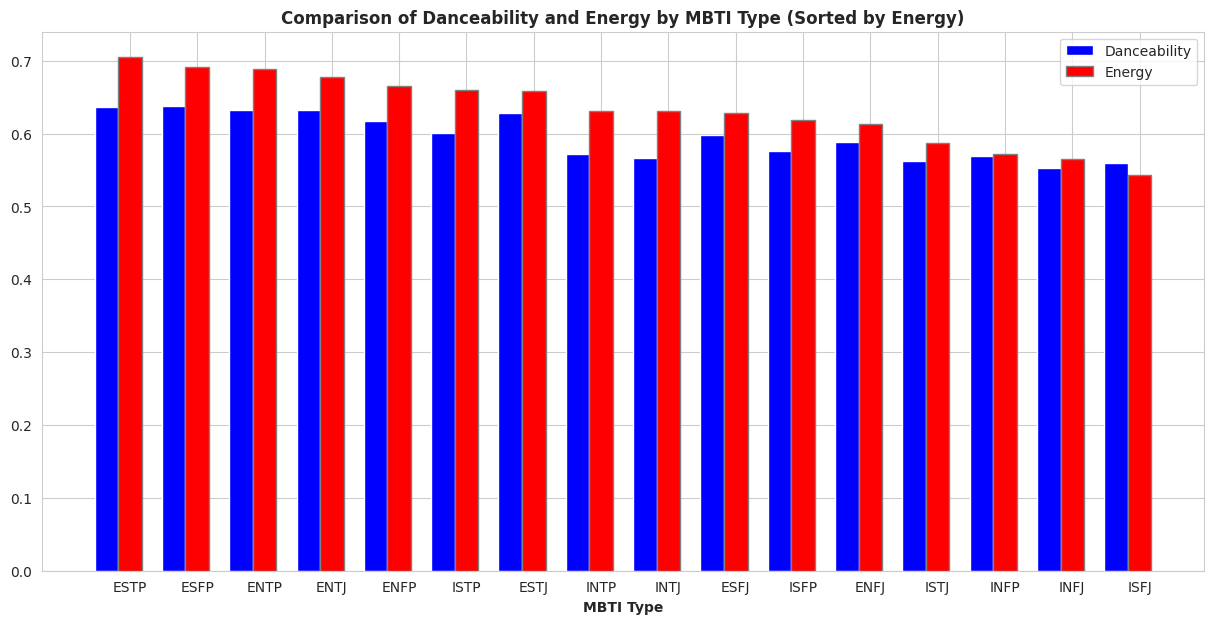

In [29]:
import numpy as np

bar_width = 0.35
agg_features_sorted = agg_features.sort_values(by='energy_mean', ascending=False)

r1 = np.arange(len(agg_features_sorted['mbti']))
r2 = [x + bar_width for x in r1]

plt.figure(figsize=(15, 7))
plt.bar(r1, agg_features_sorted['danceability_mean'], color='blue', width=bar_width, label='Danceability')
plt.bar(r2, agg_features_sorted['energy_mean'], color='red', width=bar_width, edgecolor='grey', label='Energy')

plt.title('Comparison of Danceability and Energy by MBTI Type (Sorted by Energy)', fontweight='bold')
plt.xlabel('MBTI Type', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(agg_features_sorted['mbti']))], agg_features_sorted['mbti'])

plt.legend()
plt.show()

According to the dataset we can conclude people with MBTI types ESFP, ESTP, and ENFP tend to like music that is energetic and danceable. This could mean that they prefer songs that are lively and upbeat, matching their outgoing and flexible personality.

On the other hand, people with MBTI types INFJ, ISFJ, and ISTJ tend to dislike music that is energetic and danceable. This could mean that they favor songs that are calm, introspective, or mellow, reflecting their reserved and organised personality.


Overall, there's a noticeable trend where extroverted types (E prefix) generally have a higher preference for both energy and danceability compared to introverted types (I prefix). However, there are exceptions, indicating that other factors in the MBTI classification also play a role in music preferences.

### Natural clustering of Personality Types Based on Music Features



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

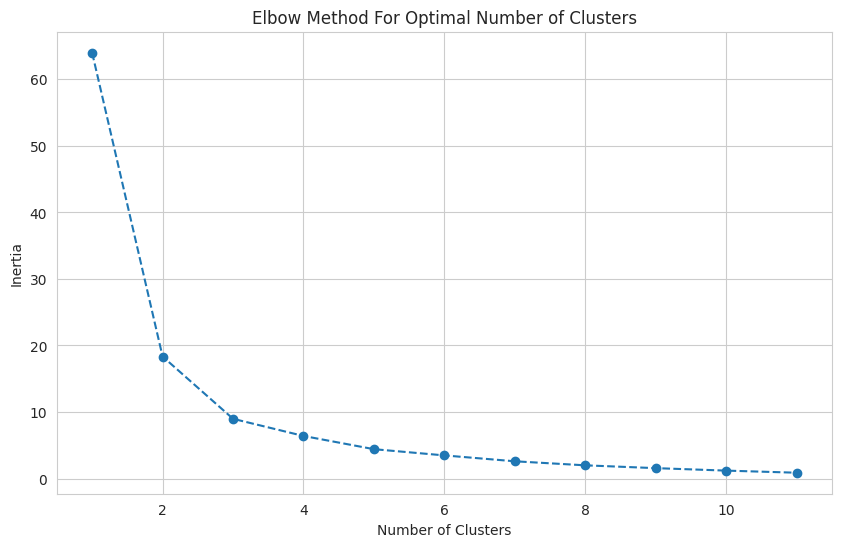

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X_scaled = StandardScaler().fit_transform(agg_features[selected_features])

inertia = []
for i in range(1, 12):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 12), inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


From the graph, it looks like the inertia begins to level off around 4 clusters. Therefore, we'll proceed with 4 clusters for the K-Means clustering.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


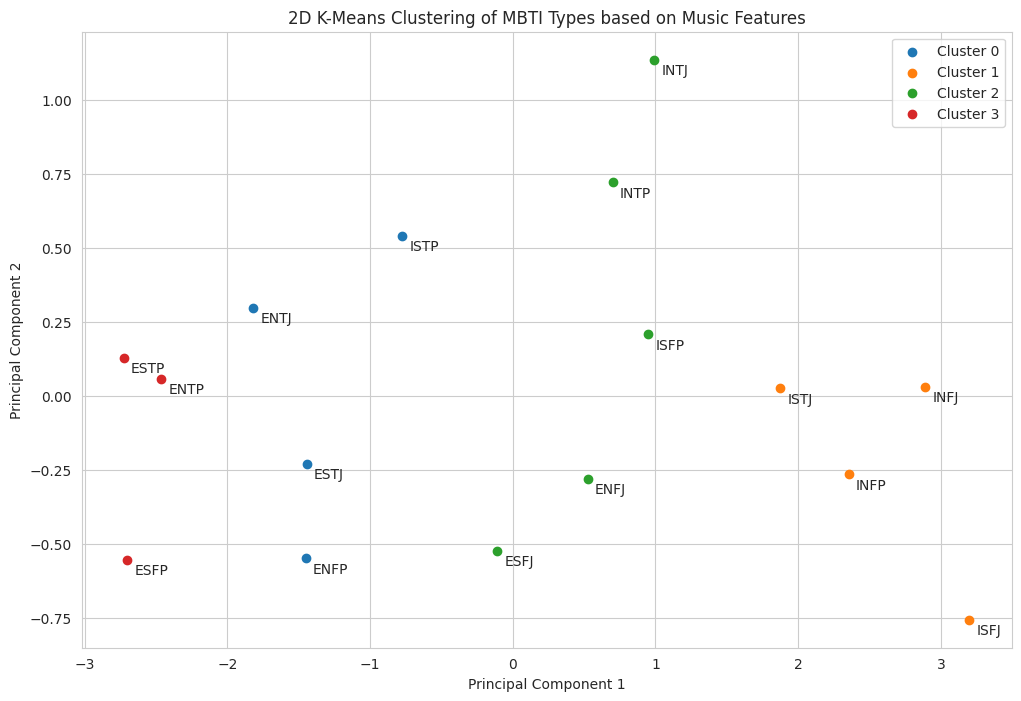

In [38]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
principal_components_2d = pca_2d.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components_2d,
                      columns=['Principal Component 1', 'Principal Component 2'])
pca_df['mbti'] = agg_features['mbti']

kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
agg_features['cluster'] = clusters

plt.figure(figsize=(12, 8))
for cluster_num in range(4):
    subset = pca_df[agg_features['cluster'] == cluster_num]
    plt.scatter(subset['Principal Component 1'], subset['Principal Component 2'], label=f"Cluster {cluster_num}")
    for i in subset.index:
        plt.text(subset.loc[i, 'Principal Component 1']+0.05,
                 subset.loc[i, 'Principal Component 2']-0.05,
                 subset['mbti'][i], fontsize=10)

plt.title('2D K-Means Clustering of MBTI Types based on Music Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


There are clearly distinguishable clusters, implying that there are sets of MBTI types that have similar music preferences. This dataset supports the hypothesis that personality might play a role in musical tastes.

### Feature "importance"
To understand feature importance, we can use several methods. One of the most common methods is to use a machine learning algorithm that provides feature importance as part of its functionality. Tree-based algorithms like Decision Trees, Random Forest, and Gradient Boosted Trees are particularly useful for this purpose.

For this analysis, we'll predict the MBTI types based on the music features and then extract the importance of each feature.

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, agg_features['mbti'])

feature_importances = rf.feature_importances_

features_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)

features_df


,Feature,Importance
0,danceability_mean,0.258911
2,acousticness_mean,0.252218
3,valence_mean,0.245292
1,energy_mean,0.243580


The danceability feature has the highest importance, suggesting that whether a track is suitable for dancing plays a significant role in distinguishing between the MBTI types.

## Model development

### Profile each MBTI type




In [42]:
core_features = [
    'acousticness_mean', 'danceability_mean', 'energy_mean', 'instrumentalness_mean',
    'liveness_mean', 'loudness_mean', 'speechiness_mean', 'tempo_mean', 'valence_mean'
]

mbti_profiles = agg_features.groupby('mbti').mean()[core_features]

mbti_profiles


,acousticness_mean,danceability_mean,energy_mean,instrumentalness_mean,liveness_mean,loudness_mean,speechiness_mean,tempo_mean,valence_mean
mbti,,,,,,,,,
ENFJ,0.276993,0.587899,0.613069,0.060069,0.171675,-7.350223,0.071001,121.698345,0.477248
ENFP,0.231054,0.617160,0.665137,0.055942,0.184654,-6.686634,0.073006,122.699232,0.530097
ENTJ,0.179875,0.631979,0.677213,0.051835,0.187273,-6.374244,0.100175,122.627487,0.495100
ENTP,0.162147,0.631851,0.688228,0.067196,0.193663,-6.378168,0.094166,123.098486,0.530731
ESFJ,0.269205,0.597484,0.628275,0.043884,0.178081,-6.906210,0.071973,120.962375,0.500124
ESFP,0.187097,0.638366,0.691941,0.041390,0.188853,-6.265767,0.083037,123.097601,0.555461
ESTJ,0.211900,0.628262,0.659110,0.073039,0.179810,-6.607564,0.094724,121.867689,0.505723
ESTP,0.161459,0.636329,0.704636,0.051824,0.195407,-6.224988,0.104276,124.639659,0.531187
INFJ,0.348565,0.552437,0.564813,0.092760,0.167733,-8.017217,0.060858,118.761481,0.412079


### Compute similarity score
For a given user's MBTI type, compute the similarity (or distance) between the user's MBTI profile and each song in the song recommendations dataset.

In [58]:
# Import Spotify db dataset for recommendations
songs_df = pd.read_csv("spotify_db_dataset.csv.zip")
songs_df.drop_duplicates(subset=['track_name', 'artist_name'], inplace=True)
songs_df.isna().sum().sum()

0

In [59]:
from scipy.spatial import distance

# Adjusting the core features list to match the song_recommendations dataset
core_features_adjusted = [feature.replace('_mean', '') for feature in core_features]

def recommend_songs(mbti_type, num_songs=10):
    profile = mbti_profiles.loc[mbti_type]

    # Computing the Euclidean distance between the MBTI profile and each song
    songs_df['distance'] = songs_df[core_features_adjusted].apply(lambda x: distance.euclidean(x, profile), axis=1)

    return songs_df.nsmallest(num_songs, 'distance')[['track_name', 'artist_name', 'genre', 'distance', 'track_id']]

recommend_songs('ENTJ')


,track_name,artist_name,genre,distance,track_id
61057,Right Here Right Now,DPR LIVE,R&B,0.306555,47UUNYT0lsDnX9EYHIBf3L
11080,That’s Just the Way That I Feel,Purple Mountains,Alternative,0.310137,1MnS69P2pIQlbiN7QYPQaH
3887,Start a Band (with Keith Urban),Brad Paisley,Country,0.332109,0GneFCOVzvi6ok0oRC7Kfu
85980,See You Around,Chris Brown,R&B,0.339580,0ixCM4Av1YkDSuOhtQ6LxZ
91383,Don't Be Nice,Watsky,Hip-Hop,0.348999,0tuE3l1TPJ9tKG4w63kgtf
6669,Hey,Red Hot Chili Peppers,Alternative,0.384535,0xAjq4KAQdJvUyCM7fFZ9K
5225,It's That Talk Again,Broken Bells,Alternative,0.385516,5C8Vwr9o1WtsoDVPFqPCob
215859,Constantly,Cross Canadian Ragweed,Country,0.391250,7LNc35QrDpp3tn7bI2e4Qa
70165,Anziety,Logic,Hip-Hop,0.391581,6CvTbrBxxc5jFwqsivhpxh
86722,Westside Love,Marc E. Bassy,R&B,0.391762,3hOT8v0uAn7gTMUbvicyma
